# 0. BMI using BMIrealtime_Func.py

In [ ]:
from bmi_module import BMIRealtime, GUIView

def main():
    prb = probe()  # 실제 값으로 대체하세요
    fetfile = './fet.bin'  # 실제 파일 경로로 대체하세요
    ttlport = 'None'  # 실제 포트 값으로 대체하세요

    # BMIRealtime 클래스 인스턴스 생성
    bmi_realtime = BMIRealtime(prb, fetfile, ttlport)

    # 필요한 변수들 설정
    bsize = 0.1
    Bbins = 10
    neuron_id = 0
    threshold = 3
    t_smooth = 3
    bmi_update_rule = 'moving_average'
    posterior_threshold = 0.01
    two_steps_decoding = False
    window_duration = 10000  # 10초
    mode = 'both'
    targetID = 0

    # 실시간 BMI 레이저 시작
    bmi_realtime.start_bmi_realtime(bsize, Bbins, neuron_id, threshold, t_smooth,
                                    bmi_update_rule, posterior_threshold, two_steps_decoding,
                                    mode, targetID, window_duration)

    # 예시로 GUIView 클래스 사용
    gui_view = GUIView()
    spike_file = 'path_to_spike_file'  # 실제 파일 경로로 대체하세요
    gui_view.plot_spike_firing_rate_and_isi(spike_file)

if __name__ == "__main__":
    main()


# 1. BMI in Ipynb

In [1]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
from IPython.display import display, clear_output

import pkgutil
import spiketag

from spiketag.realtime import BMI,Binner
from spiketag.analysis import decoder
from spiketag.base import probe


import serial

In [2]:
# reading fet file
fet_path = 'fet.bin'
fet = np.memmap(fet_path, dtype=np.int32).reshape(-1, 8)
t = fet[:, 0]  # time
grp_id = fet[:, 1]  # group id
fets = fet[:, 2:6]  # feature extraction
spk_id = fet[:, 6]  # spike id
energy = fet[:, 7]  # energy

In [3]:
# check spiketag module
package = spiketag

print(f"Modules in {package.__name__}:")
for importer, modname, ispkg in pkgutil.iter_modules(package.__path__):
    print(f"{modname} (Package: {ispkg})")

Modules in spiketag:
analysis (Package: True)
base (Package: True)
command (Package: False)
core (Package: True)
fpga (Package: True)
mvc (Package: True)
probe (Package: True)
quality (Package: True)
realtime (Package: True)
res (Package: True)
spiketag (Package: False)
utils (Package: True)
view (Package: True)


# bmi

In [4]:
def plot_raster(target_neuron_id, bmi_output, window_duration,spike_times):
    # Create the plot
#     fig, ax = plt.subplots(figsize=(10, 8))

    t = bmi_output.timestamp  # time
    spk_id = bmi_output.spk_id
    rm_t = t % 1000

    if spk_id == target_neuron_id:
        if len(spike_times) != 0:
            if spike_times[-1] > rm_t:
                plt.close()
                spike_times.clear()
        spike_times.append(rm_t)

#         ax.cla()  # Clear the previous plot
    clear_output(wait=True)
    plt.eventplot(spike_times, orientation='horizontal', linelengths=0.8)
    plt.xlim(0, 1000)
#         plt.ylim(-0.5, 0.5)
    plt.xlabel('Time (s)')
    plt.title('Real-time Raster Plot for Neuron {}'.format(target_neuron_id))

#         display(plt.gcf().show())
    plt.show();

    time.sleep(0.1)
    return spike_times

In [5]:
# send_signal_to_teensy()
def send_signal_to_teensy(bmi):
#     print("Signal")
    if bmi.TTLserial is not None:
        bmi.TTLserial.write(b'a')
        bmi.TTLserial.flush()

In [6]:
# reset_signal_to_teensy()
def reset_signal_to_teensy(bmi):
    if bmi.TTLserial is not None:
        bmi.TTLserial.write(b'b')
        bmi.TTLserial.flush()

In [7]:
# bmi laser function (mode)
def bmi_func(bmi, mode,targetID,neuron_id,threshold,window_duration):
    spike_times = []
    while True:
        frFlag = 0
        spkFlag = 0
        bmi_output = bmi.read_bmi()
        spike_times = plot_raster(targetID, bmi_output, window_duration,spike_times)
        
        if mode != "spike ID":
            bmi.binner.input(bmi_output)
            count_vec = bmi.binner.output
            sum_count = count_vec.sum(axis=0)
            if sum_count[neuron_id] >= threshold:
                frFlag = 1
        if mode != "firing rate":
            spike_id = bmi_output.spk_id
            if spike_id == targetID:
                spkFlag = 1

        if frFlag == 1 or spkFlag == 1:
            send_signal_to_teensy(bmi)
        else:
            reset_signal_to_teensy(bmi)

In [8]:
# prb file
prb_path = "prb_a2x32.prb"
prb = probe()
prb.load(prb_path)
# prb.show()
fet_path = 'fet.bin'
ttlport = '/dev/ttyACM1'

In [9]:
# bmi
def bmi_realtime_laser(bmi,bsize,Bbins,neuron_id,threshold,t_smooth
                       ,bmi_update_rule,posterior_threshold,
                      two_steps_decoding,mode,targetID,window_duration):
   
    pos_buffer_len = int(float(t_smooth) / float(bsize))
    

    bmi.bmi_update_rule = bmi_update_rule
    bmi.posterior_threshold = posterior_threshold
    bmi.pos_buffer_len = pos_buffer_len # position buffer length for moving average
    bmi.two_steps = two_steps_decoding
    BMI.set_binner(bmi,bin_size = bsize ,B_bins = Bbins)


    if bmi.binner is not None:
        try:
            
# annotated parts are made into functions
#             while True:
#                 bmi_output = bmi.read_bmi()
#                 bmi.binner.input(bmi_output)
#                 count_vec = bmi.binner.output
#                 sum_count = count_vec.sum(axis=0)
#         #         print(sum_count[neuron_id])
#                 if sum_count[neuron_id] >= threshold:
#                     send_signal_to_teensy()
#                 else:
#                     reset_signal_to_teensy()

#             bmi_loop(lambda : bmi_func(bmi,mode,targetID,neuron_id,threshold,window_duration))
            bmi_func(bmi, mode,targetID,neuron_id,threshold,window_duration)
        except KeyboardInterrupt:
            print("Terminating the loop...")
        finally:
            bmi.close() # close bmi


In [11]:
bmi = BMI(prb=prb, fetfile=fet_path, ttlport=ttlport)
# print(np.unique(spk_id))

32 groups on probe
2 groups is configured in the FPGA: [ 9 14]
9 neurons are configured in the FPGA
---1. BMI spike-model initiation succeed---



OSError: [Errno 16] Device or resource busy: '/dev/xillybus_fet_clf_32'

In [10]:
# function call parts
# you can edit the values if you need
# set var
bmi = BMI(prb=prb, fetfile=fet_path, ttlport=ttlport)
# bsize = 100e-3 # 0.1 sec
bsize = 0.1
Bbins = 10
neuron_id = 0
threshold = 3
t_smooth = 3

bmi_update_rule = 'moving_average'
posterior_threshold = 0.01
two_steps_decoding = False
# bmi = BMI(prb=prb, fetfile=fet_path, ttlport=ttlport)
# #================#
#      mode      #
# 1. firing rate #
#   2. spike ID  #
#     3. both    #
#================#
window_duration = 10000  # 10초

mode = 'both'
targetID = 0

bmi_realtime_laser(bmi,bsize,Bbins,neuron_id,threshold,t_smooth
                       ,bmi_update_rule,posterior_threshold,
                      two_steps_decoding,mode,targetID,window_duration)

32 groups on probe
2 groups is configured in the FPGA: [ 9 14]
9 neurons are configured in the FPGA
---1. BMI spike-model initiation succeed---



OSError: [Errno 16] Device or resource busy: '/dev/xillybus_fet_clf_32'

In [19]:
# count_vec
bmi.binner.output

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [34.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [75]:
bmi.fpga.configured_groups

array([ 4,  5,  6, 11, 12, 15])

In [12]:
print(bmi.TTLserial)

Serial<id=0x7f922132bf70, open=False>(port='/dev/ttyACM1', baudrate=115200, bytesize=8, parity='N', stopbits=1, timeout=0, xonxoff=False, rtscts=False, dsrdtr=False)


# DataFrame

In [ ]:
# fet to dataframe
fet_df = pd.DataFrame(fet,columns = ['t','grp_id','fets_0','fets_1','fets_2','fets_3','spk_id','energy'])
fet_df.head(10)

In [ ]:
np.unique(spk_id)

In [ ]:
# visualization time(spk_id)
plt.vlines(t[spk_id==4], 0, 1)
plt.xlim([0, 100000])

In [ ]:
# counts at each time
unique_times, counts = np.unique(t[spk_id==1], return_counts=True)
counts

In [19]:
bmi.gui_queue.get()

AttributeError: 'BMI' object has no attribute 'gui_queue'

# Laser Test

In [17]:
# bmi.read_bmi()
while True:
    send_signal_to_teensy(bmi)

SerialException: write failed: [Errno 5] Input/output error

# GUI

In [10]:
%matplotlib inline

30825


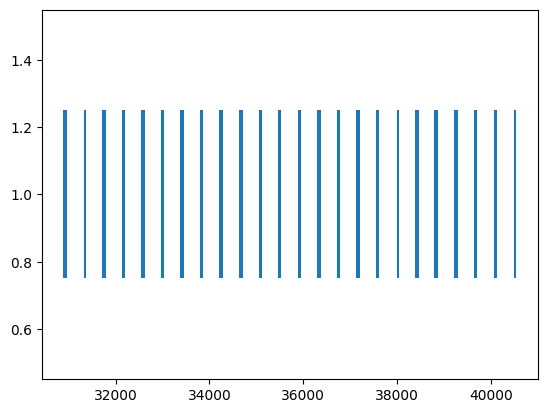

In [65]:
fet_path = 'fet.bin'
fet = np.memmap(fet_path, dtype=np.int32).reshape(-1, 8)
t = fet[:, 0]  # time
grp_id = fet[:, 1]  # group id
fets = fet[:, 2:6]  # feature extraction
spk_id = fet[:, 6]  # spike id
energy = fet[:, 7]  # energy

current_t = t[-1]
window = 10000 # 10 sec
target_id = 11

last_t = current_t - window

print(last_t)
spk_t = t[np.where((t>last_t) & (spk_id==target_id))]

plt.eventplot(spk_t, orientation='horizontal', linelengths=0.5)

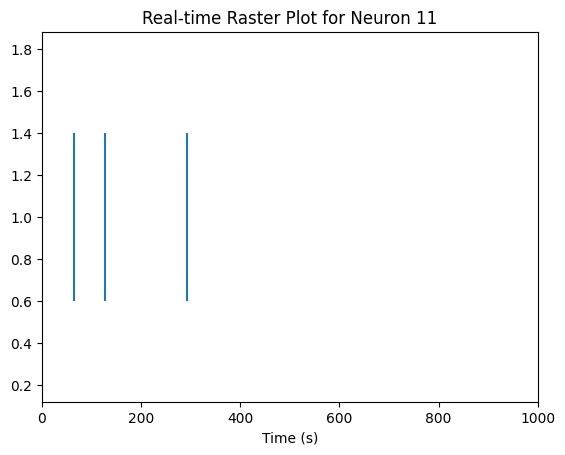

Stopped by user


In [38]:
def plot_raster(target_neuron_id, bmi, window_duration=10):
    
    # Create the plot
#     fig, ax = plt.subplots(figsize=(10, 8))
    spike_times = []

    while True:
        bmi_output = bmi.read_bmi()
        t = bmi_output.timestamp  # time
        spk_id = bmi_output.spk_id
        rm_t = t % 1000
        
        if spk_id == target_neuron_id:
            if len(spike_times) != 0:
                if spike_times[-1] > rm_t:
                    plt.close()
                    spike_times.clear()
            spike_times.append(rm_t)
        
#         ax.cla()  # Clear the previous plot
        clear_output(wait=True)
        plt.eventplot(spike_times, orientation='horizontal', linelengths=0.8)
        plt.xlim(0, 1000)
#         plt.ylim(-0.5, 0.5)
        plt.xlabel('Time (s)')
        plt.title('Real-time Raster Plot for Neuron {}'.format(target_neuron_id))
        
#         display(plt.gcf().show())
        plt.show();

        time.sleep(0.1)

# fetfile = 'fet.bin'
# ttlport = '/dev/ttyACM0'
target_neuron_id = 11
window_duration = 10000  # 10초


bmi = BMI(prb, fetfile=fet_path, ttlport=ttlport)


try:
    plot_raster(target_neuron_id, bmi, window_duration)
except KeyboardInterrupt:
    print("Stopped by user")
finally:
    bmi.close()
